In [18]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Statistics
import ProgressMeter
using Optim

In [19]:
data_seed, params_seed = 42, 120

(42, 120)

In [20]:
import ReactiveMP.messageout

In [21]:
include("../helpers/data.jl")

generate_data

In [22]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [23]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [24]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2] # TODO: fix
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [25]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [26]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [27]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 2, 2, 2
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [28]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [29]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

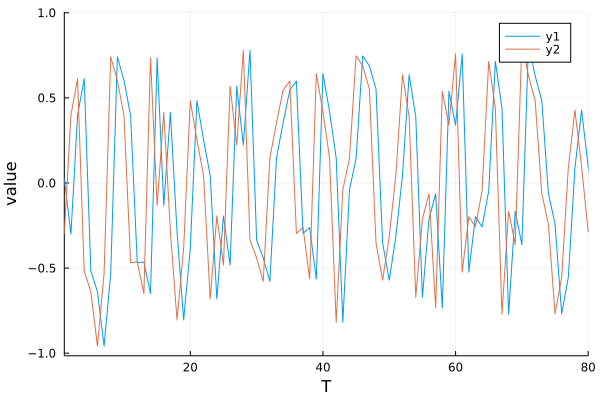

In [30]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [31]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
NN_param_len = 21
model_params = [randn(flow_param_len+NN_param_len); [0.1, 1.0]]; #Flow, NN, Gamma

In [32]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


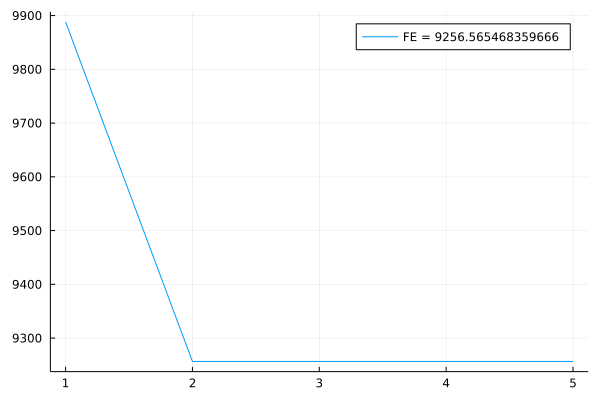

In [33]:
gr()
plot(fe, label="FE = $(fe[end])")

In [34]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.001*diageye(2)), 
                                                 vmp_its=2)
    return fe[end]
end;

In [35]:
FE(model_params)

9258.743829150459

In [21]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/fnn_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-0.254605, 1.17148, -0.86868, -0.769391, 0.00435597, 1.1494,…

In [36]:
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-12, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


┌ Warning: #= /Users/apodusenko/.julia/dev/ReactiveMP/src/algebra/helpers.jl:109 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ ReactiveMP /Users/apodusenko/.julia/packages/LoopVectorization/kVenK/src/condense_loopset.jl:825


Iter     Function value   Gradient norm 
     0     9.258744e+03     7.681542e+04
 * time: 0.01733112335205078
    10     6.589993e+02     2.024203e+03
 * time: 86.91196894645691


 * Status: success

 * Candidate solution
    Final objective value:     4.952033e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.62e+03 ≰ 1.0e-12

 * Work counters
    Seconds run:   374  (vs limit Inf)
    Iterations:    19
    f(x) calls:    253
    ∇f(x) calls:   253


In [37]:
inf_params = Optim.minimizer(res)

32-element Vector{Float64}:
 -0.580252801804151
  0.6518687369759527
 -0.32962707313315337
 -1.4818006170512816
  0.21088444744772403
  1.2546383986594212
  1.5484199146637232
 -0.935396685188285
  1.6981870138108048
 -0.14232323142064368
 -0.6660019999132363
  0.054452122494421475
  1.6708734220957806
  ⋮
 -0.3289276293524552
  0.900095839983967
  1.701098772715935
 -1.1263204800535378
 -0.4770282495177842
  0.45433786921780056
  1.0638424930497115
  0.7910951660768475
 -0.2419589969671592
 -0.3755087240813069
  3.0925873241011312
  0.03298244845420073

In [38]:
using JLD
JLD.save("../dump/flow_nn_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [39]:
FE(inf_params)

495.4566683171288

In [40]:
fe_inf, h_inf, w_inf, y_out_inf, θ_inf = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


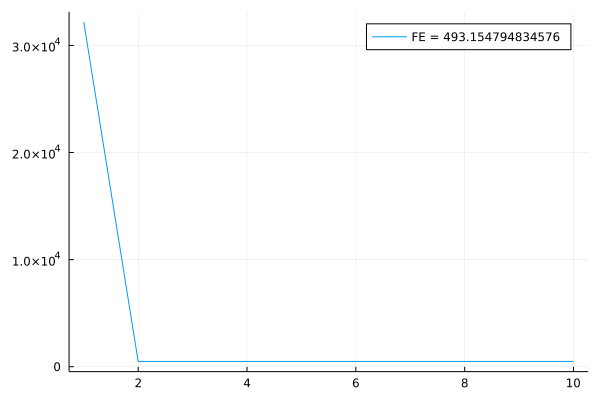

In [41]:
plot(fe_inf[1:end], label="FE = $(fe_inf[end])")

In [42]:
from, to = 100, 150

(100, 150)

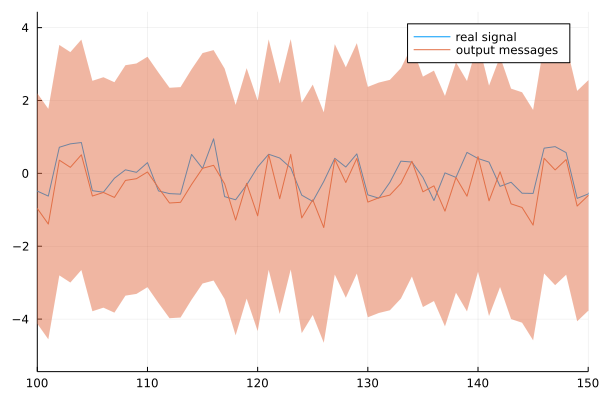

In [43]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

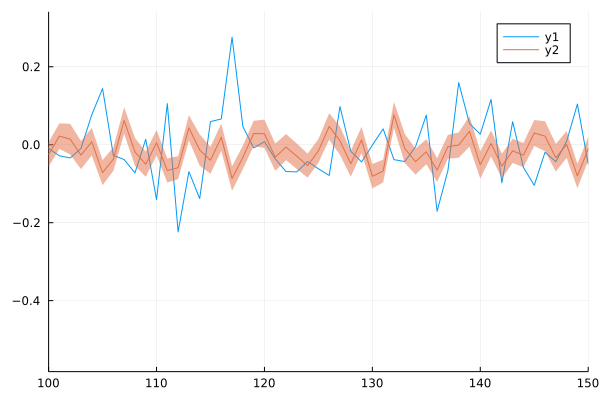

In [44]:
mh, vh = mean.(h_inf), cov.(h_inf)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [45]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [46]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)

    # initialize variables
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 1 method)

In [47]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [48]:
predictions = []
h_prev = (mean(h_inf[end]), precision(h_inf[end]))
ŵ = mean(w_inf)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [49]:
w_pred = mean(w)

0.1

In [50]:
mx, vx = mean.(predictions), cov.(predictions)

([0.17161772335173023, 0.21409034879364097, 0.23805533263069792, -1.513893192745031, -1.3039436928580004, 0.357187171632483, 0.2447947126838324, 0.13986503114844026, 0.08163379334505735, -1.0304945304049993  …  0.19273810847215736, -1.5976247778356423, -1.1230794850705357, 0.6710839271412686, 0.12322713197321793, 0.29342334344602916, 0.6440086321269516, -1.7527930756360726, -1.2862527336138003, 0.6854737461855072], [0.17893595608078963, 0.17774131871688612, 0.17605523646350332, 0.17508753660754453, 0.1766515684793522, 0.18126632417374658, 0.1787806951787002, 0.1773109234825152, 0.17587715395566214, 0.1751499333702024  …  0.17606511961665694, 0.1752343836783811, 0.17696806458733022, 0.17871302106513773, 0.17723940510419575, 0.17733798973647613, 0.17652169709000975, 0.17510347088822575, 0.17627280924311498, 0.18226152197908205])

In [51]:
test_from, test_to = 150, 200

(150, 200)

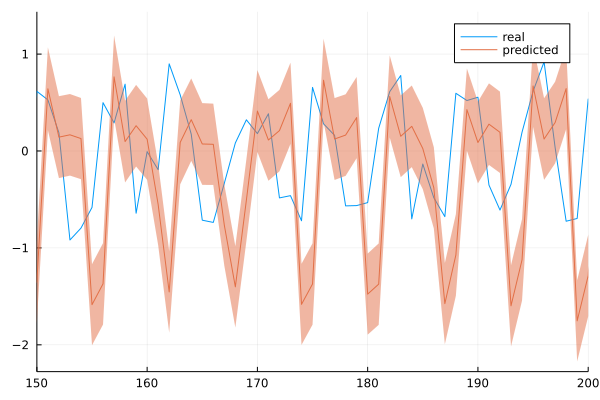

In [52]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [53]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

201-element Vector{Float64}:
  4.159162660604494
  4.147417410872042
  1.142022496309359
 -2.724907528266212
 -2.4145233626486347
  2.8585793920718396
  4.207540224308777
  3.943768044042402
  1.7493517833416492
 -2.221141156497051
 -2.874284036429988
 -0.7862187651430393
  3.665643709097024
  ⋮
  4.073654403130121
  4.079670478191165
  0.24774691083904019
 -2.821114189036212
 -1.8611445143369707
  3.2096609478806117
  4.134301164804227
  4.271526469506373
  2.6473831135714114
 -2.8801934075650752
 -2.933975201657648
  3.4299325797679607

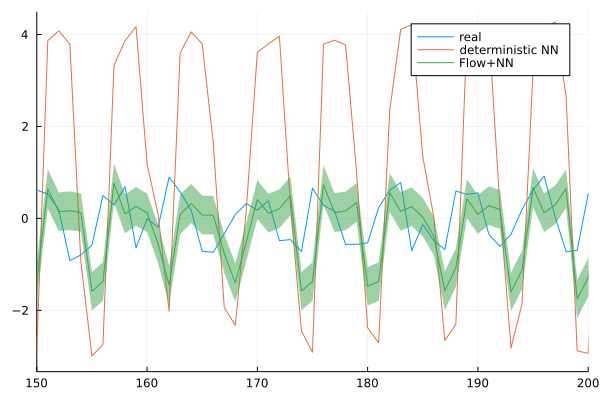

In [54]:
plot(Y_test, label="real")
plot!(n_output, label="deterministic NN")
plot!(mx, ribbon=sqrt.(vx), label="Flow+NN", xlims=(test_from, test_to))